In [3]:
import sys  
sys.path.insert(0, '../../src/')
import matplotlib.pyplot as plt



import featureExtraction as fe
import numpy as np
import pandas as pd

import metrics as mt
import pickle


In [4]:
WINDOW_SIZE = 256
OVERLAP_FACTOR = 0.5

fe_dataset = fe.FeatureExtractor('ours', WINDOW_SIZE, OVERLAP_FACTOR)
fe_dataset.extract_features()


save_path = '../data/'

# Save the model
with open(save_path+'fe_dataset.pkl', 'wb') as file:
    pickle.dump(fe_dataset, file)


Loading processed dataset with Window_size=256, Overlap=0.5 and name=ours...
Please wait, this loading could last some minutes...
../data/Window256Overlap0.5/labels.txt - loaded succesfully
../data/Window256Overlap0.5/users.txt - loaded succesfully
../data/Window256Overlap0.5/train.txt - loaded succesfully
../data/Window256Overlap0.5/val.txt - loaded succesfully
../data/Window256Overlap0.5/test.txt - loaded succesfully
../data/Window256Overlap0.5/sensors(145502, 256, 9).txt - loaded succesfully
Extracting features...


100%|██████████| 145502/145502 [00:43<00:00, 3364.85it/s]


Resultant features shape: (145502, 99)


In [5]:

# Load unnormalized dataset
with open('../data/'+'fe_dataset.pkl', 'rb') as file:
    fe_dataset = pickle.load(file)

In [6]:
def column_names():
    names = []
    for sensor in ["acc","mag","gyro"]:
        for axis in ["x","y","z"]:
            for feature in ["mean","median","stds","vars","mins","max","mean-crossings","mean-fft","energy","entropy","zero-crossing"]:
                names.append(sensor+"_"+axis+"_"+feature)
    return names

feature_names = column_names()
df = pd.DataFrame(fe_dataset.features.copy(),columns = feature_names)
df.insert(len(feature_names), "label", fe_dataset.labels, True)

In [7]:
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from keras.utils import to_categorical

label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(fe_dataset.labels.copy())

# Check the order of classes
print("Classes:",label_encoder.classes_)
labels = to_categorical(labels)


Classes: ['Bike' 'Bus' 'Car' 'Metro' 'Moto' 'Run' 'Stationary' 'Train' 'Tram'
 'Walk' 'e-Bike' 'e-Scooter']


In [8]:
#CUSTOM SPLITTING
train =fe_dataset.features[fe_dataset.idx_train]
train_labels =fe_dataset.labels[fe_dataset.idx_train]
test =fe_dataset.features[fe_dataset.idx_test]
test_labels =fe_dataset.labels[fe_dataset.idx_test]

In [9]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score

In [10]:
#~2min
model = RandomForestClassifier(n_estimators= 500, min_samples_split= 10,min_samples_leaf= 5,max_features= 'log2', max_depth= 50, bootstrap= True,random_state=42)
model.fit(fe_dataset.features[fe_dataset.idx_train], fe_dataset.labels[fe_dataset.idx_train])
y_pred = model.predict(fe_dataset.features[fe_dataset.idx_val])
print("Accuracy:", accuracy_score(fe_dataset.labels[fe_dataset.idx_val], y_pred))

Accuracy: 0.8346622674365319


In [11]:
class_names = label_encoder.classes_

true_labels = fe_dataset.labels[fe_dataset.idx_test]
true_labels

predictions = model.predict(fe_dataset.features[fe_dataset.idx_test])
predictions

array(['Metro', 'Car', 'Bus', ..., 'Metro', 'Metro', 'Tram'], dtype='<U10')

In [12]:
def column_names_short():
    names = []
    for sensor in ["Ac","Mg","Gy"]:
        for axis in ["X","Y","Z"]:
            for feature in ["mean","median","stds","vars","mins","max","m-cross","mean-fft","energy","entropy","z-cross"]:
                names.append(sensor+axis+"-"+feature)
    return names

feature_names_short = column_names_short()

In [13]:
##indexes of correctly predicted samples
correctly_predicted = {}

#indexes of incorrectly predicted samples, inc_pred["Car"] contains car samples labeled as other classes by the classifier
incorrectly_predicted = {}

for c in class_names: 
    correctly_predicted.update({c:[]})
    incorrectly_predicted.update({c:[]})

for idx, _ in enumerate(test):
    if(true_labels[idx] == predictions[idx]): correctly_predicted[true_labels[idx]].append(idx)
    else: incorrectly_predicted[true_labels[idx]].append(idx)
    

## BUILT-IN FEATURE IMPORTANCE


In [ ]:
# Creating a seaborn bar plot
feature_scores = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)

C:\Users\miquel\AppData\Local\Temp\ipykernel_26424\227555481.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=feature_scores, y=feature_scores.index, palette=np.array(pal[::-1])[rank])
C:\Users\miquel\AppData\Local\Temp\ipykernel_26424\227555481.py:7: UserWarning: Numpy array is not a supported type for `palette`. Please convert your palette to a list. This will become an error in v0.14
  ax = sns.barplot(x=feature_scores, y=feature_scores.index, palette=np.array(pal[::-1])[rank])
C:\Users\miquel\AppData\Local\Temp\ipykernel_26424\227555481.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(feature_scores.index)


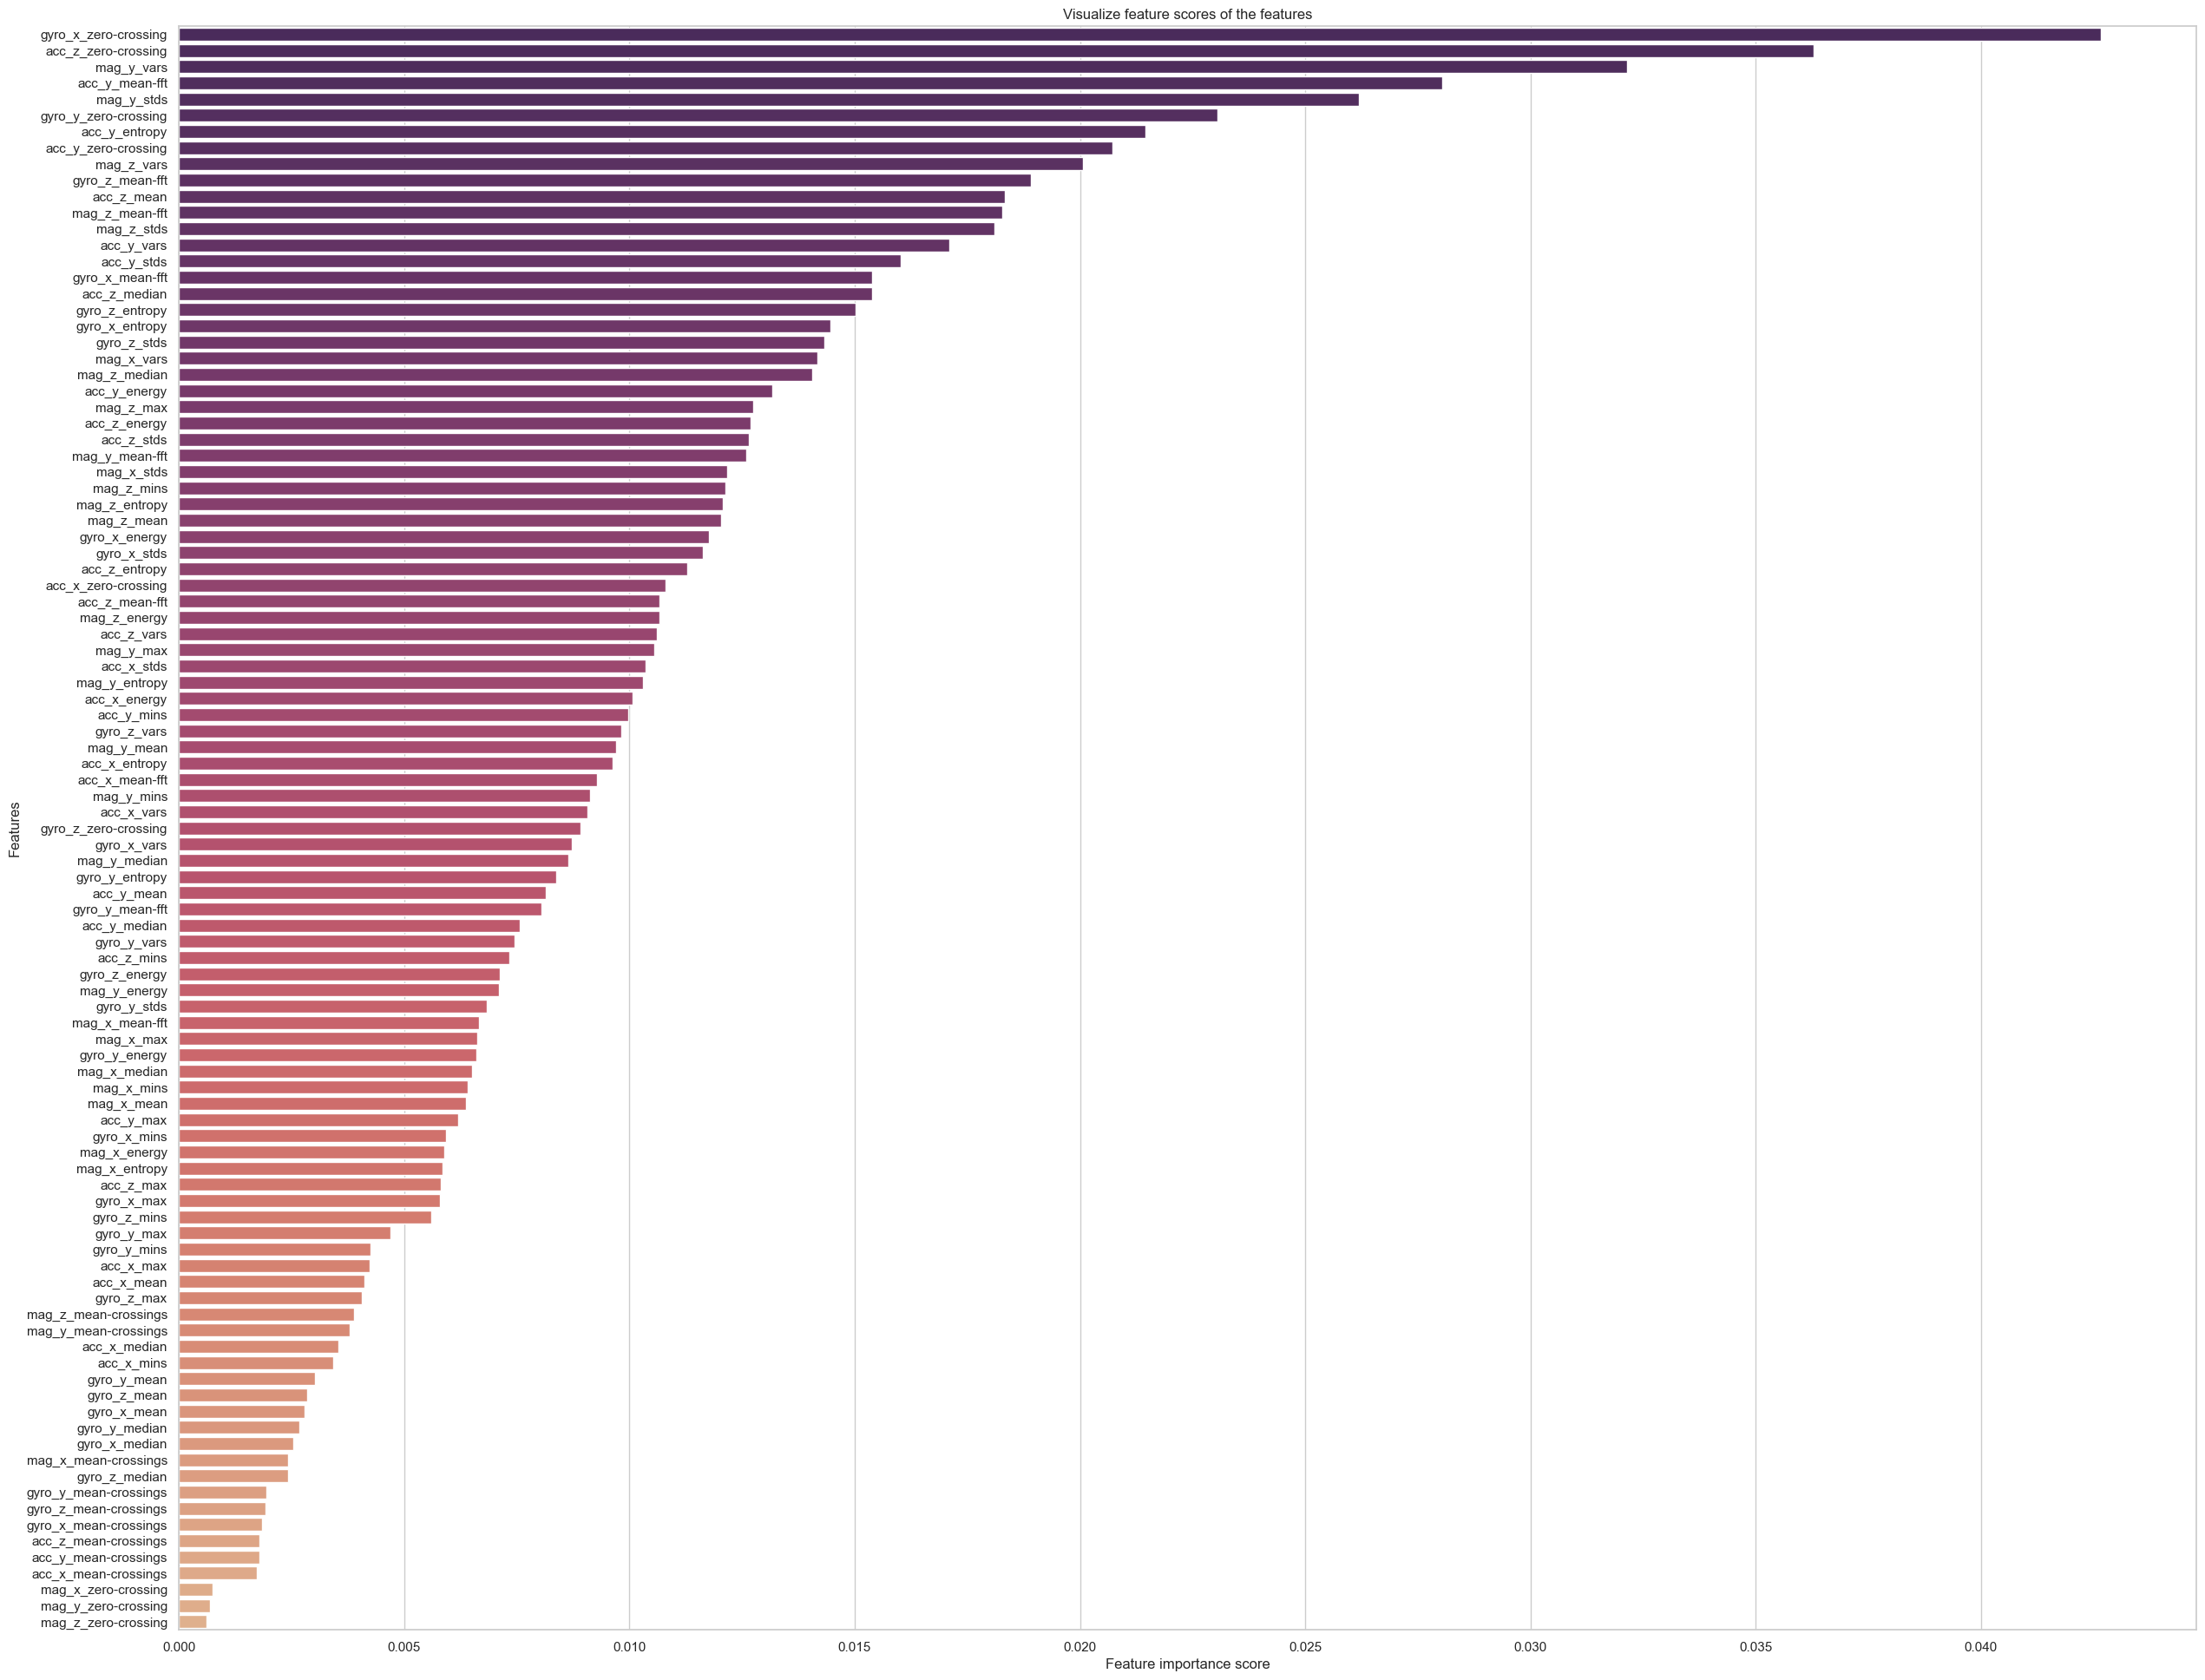

In [ ]:

import seaborn as sns
sns.set(style="whitegrid")
pal = sns.color_palette("flare_r", len(feature_scores))
rank = feature_scores.argsort().argsort() 

f, ax = plt.subplots(figsize=(30, 24))
ax = sns.barplot(x=feature_scores, y=feature_scores.index, palette=np.array(pal[::-1])[rank])
ax.set_title("Visualize feature scores of the features")
ax.set_yticklabels(feature_scores.index)
ax.set_xlabel("Feature importance score")
ax.set_ylabel("Features")
plt.show()



In [15]:
car_sample = 16196
walk_sample = 6201
confusion_car_sample = 1181

## LIME

In [ ]:
# Import the LimeTabularExplainer module
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(train, feature_names =     
                                 feature_names_short,
                                 class_names = class_names, 
                                 mode = 'classification')

In [ ]:
import random
#chose the sample to analize
class_ = "Walk"
idx = correctly_predicted[class_][random.randint(0,len(correctly_predicted[class_])-1)]
# idx = car_sample

print('id: %d' % idx)
print('Predicted class =', predictions[idx])
print('True class: %s' % true_labels[idx])

idx_predLabel = np.where(class_names == predictions[idx])[0][0]
idx_trueLabel = np.where(class_names == true_labels[idx])[0][0]
test_instances = test[idx]
exp = explainer.explain_instance(test_instances, model.predict_proba,num_features=10, labels=[idx_predLabel,idx_trueLabel])
exp.show_in_notebook(show_table=True,show_all = False)
exp.save_to_file('lime.html')

id: 2174
Predicted class = Walk
True class: Walk


## SHAP


In [16]:
import shap
samples = test[[car_sample,walk_sample,confusion_car_sample]]


In [ ]:

# ~2min for 100 samples
explainer = shap.Explainer(model,feature_names=feature_names)
shap_values = explainer(train[0:99])

In [ ]:
# ~2min for 100 samples
tree_explainer = shap.TreeExplainer(model,feature_names=feature_names)
tree_shap_values = tree_explainer(train[0:99])

print(shap_values.shape)
tree_shap_values

In [ ]:
# ~2min for 100 samples, but not very good aproxiations
kernel_explainer = shap.KernelExplainer(model.predict_proba, shap.sample(train, 100),feature_names=feature_names)
kernel_shap_values = kernel_explainer.shap_values(test[0:99],nsamples =200)
kernel_shap_values

In [ ]:
# !jupyter trust RF_explanations.ipynb
# shap.initjs()

Signing notebook: RF_explanations.ipynb


In [17]:
explainer = shap.Explainer(model,feature_names=feature_names)
shap_values = explainer(samples)

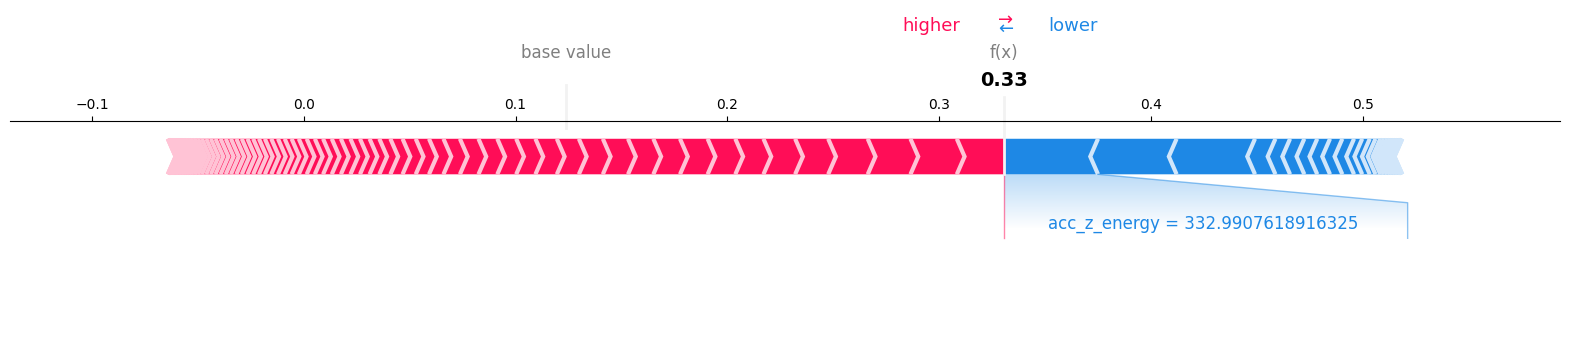

In [18]:
id_to_explain = 2
label = 9
transport_label = 0
shap.force_plot(shap_values[id_to_explain,:,label],matplotlib=True)

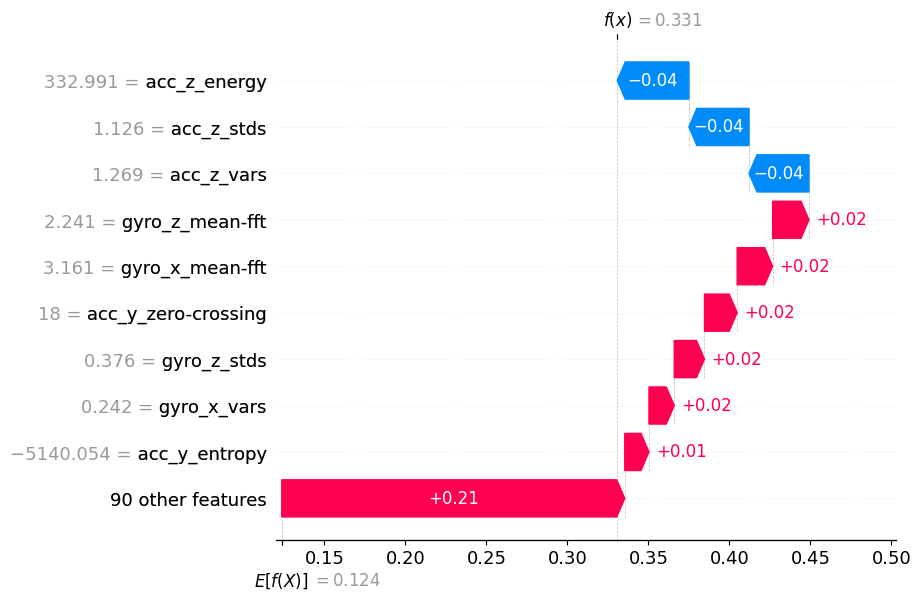

In [19]:
#CAR code 2
#WALK code 9
# samples[car_sample,walk_sample, confused_car_sample]
id_to_explain = 2
label = 9
shap.plots.waterfall(shap_values[id_to_explain,:,label])